In [1]:
import numpy as np
import lmfit
import elli
from scipy.linalg import svd
import matplotlib.pyplot as plt
import random

In [2]:
#Initialization of conditions for transmission simulations
random.seed(42)
lam0 = np.linspace(8000, 14000, 201) #wavelegths [nm]
rii_db = elli.db.RII() #initializing object containing database of refractive indexes
Silicon = rii_db.get_mat(book='Si', page='Shkondin')
Ti = rii_db.get_mat(book='Ti', page='Rakic-LD')

d_ti = 6 # Thickness in titanium [nm]

In [3]:
#Function which reconstructs Matrix with optimal thicknesses and its singular values
def ReconstructionOfM(result):

    #Reasigning thicknesses
    optimal_thickness_results=np.zeros(10)
    for i in range(10):
        optimal_thickness_results[i]=result.params[f'f{i}'].value


    #Size of wheel matrixes and M matrix
    W1=np.zeros((5,len(lam0)))
    W2=np.zeros((5,len(lam0)))
    M=np.zeros((35, len(lam0)))

    #Simulating transmissions
    following_index=0
    for i in range(W1.shape[0]):
        multi_Si_Ti = [elli.Layer(Silicon, optimal_thickness_results[following_index]), elli.Layer(Ti, d_ti)] #Filter structures silicon on top of the titanium

        model_Si_Ti_Si  = elli.Structure(elli.AIR, multi_Si_Ti, Silicon) # We structure the filters with environment and semi-infinite substrate
        model_Si = elli.Structure(elli.AIR, [], Silicon) #Reference model

        data_Si_Ti_Si = model_Si_Ti_Si.evaluate(lam0, 0, elli.Solver2x2) #wavelengths, angle of incidence. solver
        data_Si = model_Si.evaluate(lam0, 0, elli.Solver2x2)

        W1[i,:]=data_Si_Ti_Si.T*data_Si.T/(1 - data_Si.R*data_Si_Ti_Si.R)
        following_index+=1


    for j in range(W2.shape[0]):
        multi_Si_Ti = [elli.Layer(Silicon, optimal_thickness_results[following_index]), elli.Layer(Ti, d_ti)] #Filter structures silicon on top of the titanium

        model_Si_Ti_Si  = elli.Structure(elli.AIR, multi_Si_Ti, Silicon) # We structure the filters with environment and semi-infinite substrate
        model_Si = elli.Structure(elli.AIR, [], Silicon) #Reference model

        data_Si_Ti_Si = model_Si_Ti_Si.evaluate(lam0, 0, elli.Solver2x2) #wavelengths, angle of incidence. solver
        data_Si = model_Si.evaluate(lam0, 0, elli.Solver2x2)

        W2[j,:]=data_Si_Ti_Si.T*data_Si.T/(1 - data_Si.R*data_Si_Ti_Si.R)
        following_index+=1

    #Construction of the matrix M first 25 rows combinations between filters and next 10 are just individual filters
    following_index=0
    for i in range(W1.shape[0]):
        for j in range(W2.shape[0]):
            M[following_index,:]=W1[i,:]*W2[j,:]
            following_index+=1

    for i in range(W1.shape[0]):
        M[following_index,:]=W1[i,:]
        following_index+=1

    for i in range(W2.shape[0]):
        M[following_index,:]=W2[i,:]
        following_index+=1

    _,s,_=svd(M,full_matrices=False)

    return M,s

In [25]:
#objective functions
def objective(params):

    N=6#filters slots

    #Leaving one hole for each wheel for transmission of filters
    di=np.zeros(N-1)
    dj=np.zeros(N-1)


    thickness_index=0
    for i in range(N-1):
        di[i]=params[f'f{thickness_index}'].value
        thickness_index+=1

    for j in range(N-1):
        dj[j]=params[f'f{thickness_index}'].value
        thickness_index+=1


    #Reserving space for wheel matrices and M matrix
    W1=np.zeros((N-1,len(lam0)))
    W2=np.zeros((N-1,len(lam0)))
    M=np.zeros((N*N-1, len(lam0)))

    #Transmission simulations
    for i in range(W1.shape[0]):
        multi_Si_Ti = [elli.Layer(Silicon, di[i]), elli.Layer(Ti, d_ti)] #Filter structures silicon on top of the titanium

        model_Si_Ti_Si  = elli.Structure(elli.AIR, multi_Si_Ti, Silicon) # We structure the filters with environment and semi-infinite substrate
        model_Si = elli.Structure(elli.AIR, [], Silicon) #Reference model

        data_Si_Ti_Si = model_Si_Ti_Si.evaluate(lam0, 0, elli.Solver2x2) #wavelengths, angle of incidence. solver
        data_Si = model_Si.evaluate(lam0, 0, elli.Solver2x2)

        # Correction of the final transmission from the effect of the substrate
        W1[i,:]=data_Si_Ti_Si.T*data_Si.T/(1 - data_Si.R*data_Si_Ti_Si.R)


    for j in range(W2.shape[0]):
        multi_Si_Ti = [elli.Layer(Silicon, dj[j]), elli.Layer(Ti, d_ti)] #Filter structures silicon on top of the titanium

        model_Si_Ti_Si  = elli.Structure(elli.AIR, multi_Si_Ti, Silicon) # We structure the filters with environment and semi-infinite substrate
        model_Si = elli.Structure(elli.AIR, [], Silicon) #Reference model

        data_Si_Ti_Si = model_Si_Ti_Si.evaluate(lam0, 0, elli.Solver2x2) #wavelengths, angle of incidence. solver
        data_Si = model_Si.evaluate(lam0, 0, elli.Solver2x2)

        # Correction of the final transmission from the effect of the substrate
        W2[j,:]=data_Si_Ti_Si.T*data_Si.T/(1 - data_Si.R*data_Si_Ti_Si.R)

    #Construction of the matrix M first 25 rows combinations between filters and next 10 are just individual filters
    following_index=0
    for i in range(W1.shape[0]):
        for j in range(W2.shape[0]):
            M[following_index,:]=W1[i,:]*W2[j,:]
            following_index+=1

    for i in range(W1.shape[0]):
        M[following_index,:]=W1[i,:]
        following_index+=1

    for i in range(W2.shape[0]):
        M[following_index,:]=W2[i,:]
        following_index+=1


    _,s,_=svd(M,full_matrices=False)


    objective_values.append(np.linalg.norm(1/s,ord=2)) #storing norm of output vector
    singular_values_atiter.append(s) #storing singular values at each iteration

    return 1/s


In [5]:
#parameter object initialization
params=lmfit.Parameters()

In [6]:
#Setting 10 random thickness of silicon from the uniform distribution
for i in range(10):
    params.add(f'f{i}', value=random.uniform(1000,6000),min=1000,max=6000)

In [26]:
#For storing results for further analysis
objective_values=[]
singular_values_atiter=[]

In [27]:
#configuring optimizer
minimizer = lmfit.Minimizer(objective, params)
result = minimizer.minimize(method='nelder-mead')

In [28]:
#Storing sum of the singular values close to one
num_singval=[]
for i in range(len(singular_values_atiter)):
    num_singval.append(np.sum(np.abs((1-singular_values_atiter[i]))<0.5))


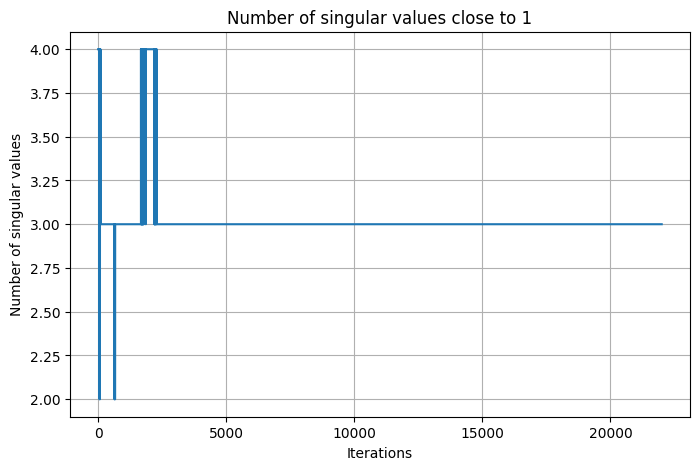

In [29]:
plt.figure(figsize=(8,5))
plt.plot(num_singval)
plt.title('Number of singular values close to 1')
plt.xlabel('Iterations')
plt.ylabel('Number of singular values')
plt.grid()

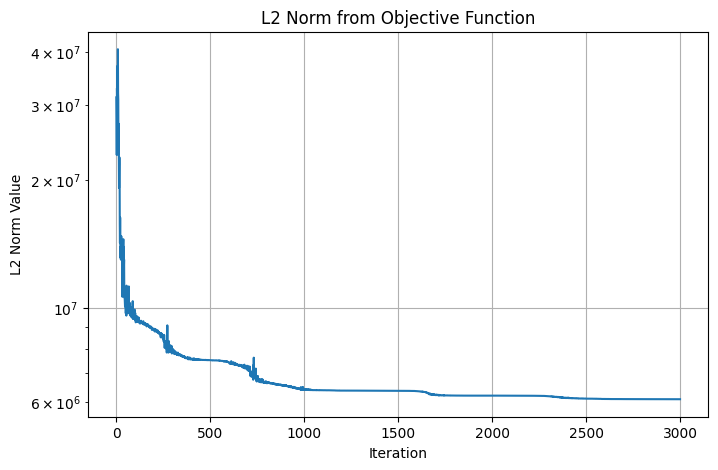

In [36]:
plt.figure(figsize=(8,5))
plt.semilogy(objective_values[:3000])
plt.title('L2 Norm from Objective Function')
plt.ylabel('L2 Norm Value')
plt.xlabel('Iteration')
plt.grid(True)  # Improves visibility
plt.show()

In [31]:
M,s=ReconstructionOfM(result)

Text(0, 0.5, 'Values')

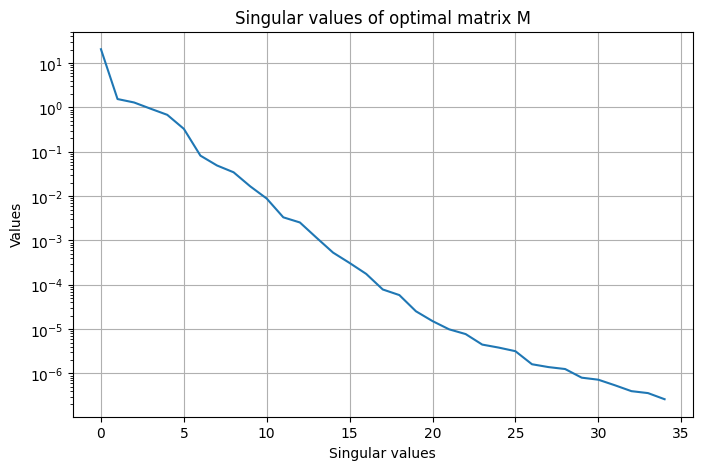

In [34]:
plt.figure(figsize=(8,5))
plt.grid()
plt.semilogy(s)
plt.title('Singular values of optimal matrix M')
plt.xlabel('Singular values')
plt.ylabel('Values')

In [35]:
result